In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
# from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from itertools import permutations 
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_recall_fscore_support, hamming_loss, jaccard_score

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ica

import trimesh

import sys
sys.path.append('/data/users2/yxiao11/model/satellite_project/')

from moduler import *

# import sys
# sys.path.append('/data/users2/yxiao11/mangoDB/wirehead')
# from wirehead import WireheadGenerator
# from wirehead import MongoTupleheadDataset, MongoheadDataset

# torch.set_printoptions(sci_mode=False)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def safe_load_numpy(file_path, retries=5, wait=0.1):
    for attempt in range(retries):
        try:
            data = np.load(file_path)   # Attempt to load
            return data                 # Success! Immediately returns
        except (FileNotFoundError, OSError, ValueError) as e:
            if attempt < retries - 1:   # Not the last attempt? Wait, then try again
                time.sleep(wait)
            else:                       # Last attempt and still fails
                raise e

def random_shift_pair(cube, mask):
    """
    Apply the same random circular shift to both a [n, d, d] cube and a [d, d] mask.
    
    Args:
        cube (torch.Tensor): shape [n, d, d]
        mask (torch.Tensor): shape [d, d]
        
    Returns:
        shifted_cube: Tensor of shape [n, d, d]
        shifted_mask: Tensor of shape [d, d]
    """
    assert cube.ndim == 3 and mask.ndim == 2, "Expected cube [n, d, d] and mask [d, d]"
    assert cube.shape[1:] == mask.shape, "Spatial dimensions must match"

#     d = mask.shape[0]
    d = 6
    shift_x = torch.randint(0, d, (1,)).item()  # shift in width (columns)
    shift_y = torch.randint(0, d, (1,)).item()  # shift in height (rows)

    shifted_cube = torch.roll(cube, shifts=(shift_y, shift_x), dims=(1, 2))
    shifted_mask = torch.roll(mask, shifts=(shift_y, shift_x), dims=(0, 1))

    return shifted_cube, shifted_mask

class get_dataset(Dataset):
    def __init__(self, data_dir, labels_dir):
        self.data_dir = data_dir
        self.labels_dir = labels_dir

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        ipt = safe_load_numpy(self.data_dir[idx])
#         ipt = (ipt - ipt.mean(axis=(1,2), keepdims=True)) / (ipt.std(axis=(1,2), keepdims=True)+ 1e-8)
        ipt = torch.from_numpy(ipt)
        # ipt,_,_ = ica.pca_whiten(ipt.reshape(100,-1), 10)
        # ipt = torch.from_numpy(ipt.reshape(10,32,32))

        tgt = torch.from_numpy(safe_load_numpy(self.labels_dir[idx]))
    
        # tgt = torch.from_numpy(safe_load_numpy(self.labels_dir[idx])[None,:]).float()
        # tgt = (tgt - tgt.mean(axis=(1,2), keepdims=True)) / (tgt.std(axis=(1,2), keepdims=True)+ 1e-8)


        # label_index = torch.from_numpy(safe_load_numpy(self.labels_dir[idx])).long()
        # label = torch.zeros(71)
        # label[label_index] = 1

        # label = torch.tensor([0, 1]).repeat(71, 1)
        # label[label_index] = torch.tensor([1, 0])

#         ipt, tgt = random_shift_pair(ipt,tgt)
        
        return ipt.float(), tgt.long()
    



In [4]:
# data_type = 'mixed'
data_type = 'Pristine'
# data_type = 'Irradiated'

batch_size=10

blur_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/blur_cube/'
label_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/spectral_cube/'
# label_dir = '/data/users2/yxiao11/model/satellite_project/data/' +data_type + '/label/'

blur_file = []
label_file = []
# spectral_file = []
for i in range(len(os.listdir(blur_dir))):
    blur_file.append(blur_dir + f"{i}.npy")
    label_file.append(label_dir + f"{i}.npy")
#     spectral_file.append(spectral_dir + f"{i}.npy")
    
# Load dataset
my_dataset = get_dataset(blur_file, label_file)




# # Define split ratio
# train_size = int(0.1 * len(my_dataset))  # 10% training
# test_size = len(my_dataset) - train_size  # 90% testing

# # Randomly split dataset
# my_dataset, test_dataset = random_split(my_dataset, [train_size, test_size])

# Print dataset sizes
print(f"Total samples: {len(my_dataset)}")
# print(f"Training samples: {len(train_dataset)}")
# print(f"Testing samples: {len(test_dataset)}")

test_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

Total samples: 1000


In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CubeModel(21, 19).to(device)

# model = RNNFeatureExtractor(19, 0.1).to(device)
# model = torch.load("/data/users2/yxiao11/model/satellite_project/resluts_n_model/model.pth")

model = torch.jit.load("/data/users2/yxiao11/model/satellite_project/resluts_n_model/model.pt")

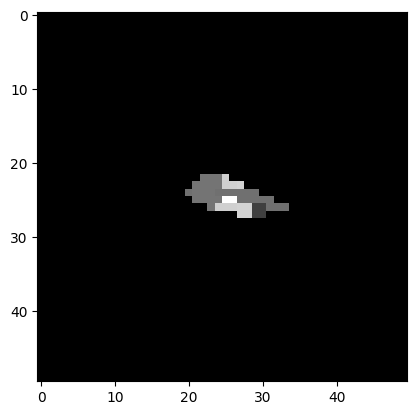

In [75]:
cube, labels = next(iter(test_loader))
cube = cube.to(device)
plt.imshow(labels[0].cpu().detach().numpy(), 'gray')

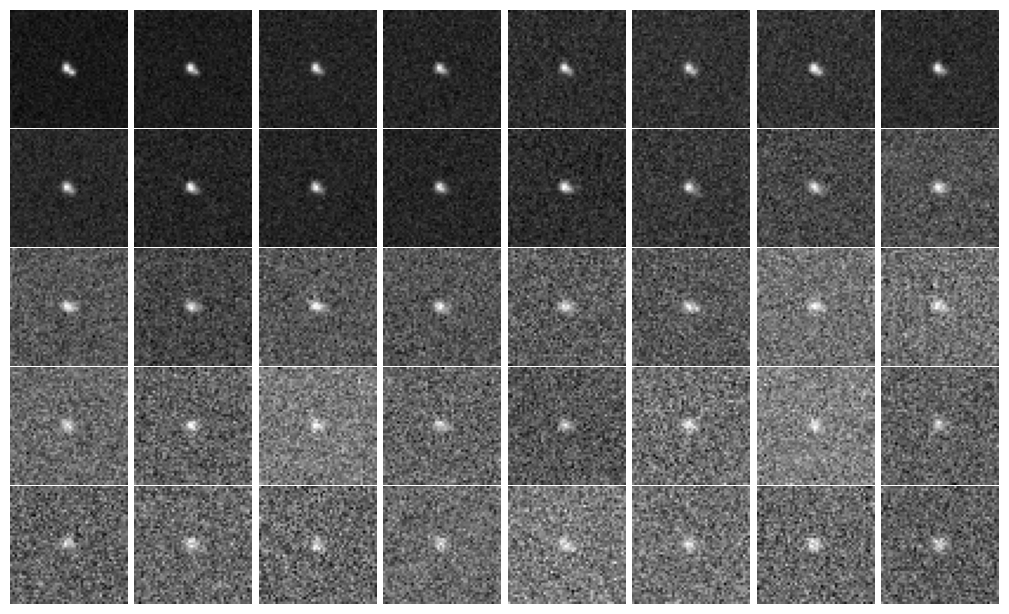

In [76]:
count = 0
plt.figure(figsize=(10,6))
row,col = 5,8
for i in range(row):
    for j in range(col):
        plt.subplot(row,col,count+1)
        
        plt.imshow(cube.cpu().detach().numpy()[0][count], cmap='gray')
        plt.axis('off')
        count+=1

# Reduce spacing between plots
plt.tight_layout(pad=0.2)  # Try values like 0.1, 0.2, or 0.5 for tighter layout
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()

# count = 0
# plt.figure(figsize=(10,8))
# row,col = 1,4
# for i in range(row):
#     for j in range(col):
#         plt.subplot(row,col,count+1)
        
#         plt.imshow(cube.cpu().detach().numpy()[0][4*count], cmap='nipy_spectral')
#         plt.axis('off')
#         count+=1

# # Reduce spacing between plots
# plt.tight_layout(pad=0.2)  # Try values like 0.1, 0.2, or 0.5 for tighter layout
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
# plt.show()

In [77]:
opt = model(cube)
probs = F.softmax(opt,dim=1)
opt = torch.argmax(opt, dim=1)

In [78]:
print(np.unique(labels[0].cpu().detach().numpy()))
print(np.unique(opt[0].cpu().detach().numpy()))

[ 0 16 28 29 52 53 64]
[ 0  2 28 29]


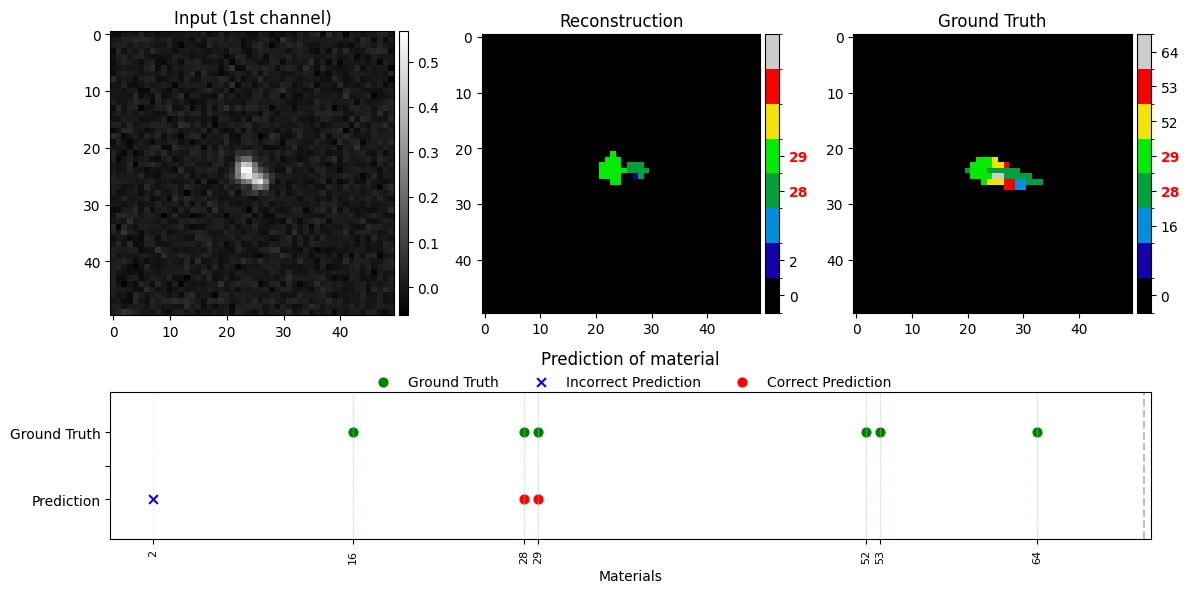

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === Load data ===
true_labels = labels[0].cpu().numpy()
pred_labels = opt[0].cpu().numpy()
input_image = cube.cpu().detach().numpy()[0][0]

# === Global mapping from class value to color index ===
all_vals = sorted(set(np.unique(true_labels)) | set(np.unique(pred_labels)))
val_to_idx_global = {v: i for i, v in enumerate(all_vals)}
num_vals = len(all_vals)
global_cmap = plt.get_cmap('nipy_spectral', num_vals)
global_norm = mcolors.BoundaryNorm(np.arange(num_vals + 1) - 0.5, num_vals)

# === Remap both labels using global color index ===
remapped_true = np.vectorize(val_to_idx_global.get)(true_labels)
remapped_pred = np.vectorize(val_to_idx_global.get)(pred_labels)

# === Dot plot data (unchanged) ===
num_classes = 72
gt = set(np.unique(true_labels)) - {0}
pred = set(np.unique(pred_labels)) - {0}
gt_array = np.zeros(num_classes)
pred_array = np.zeros(num_classes)
for i in gt: gt_array[i] = 1
for i in pred: pred_array[i] = 1
matched = gt & pred

groups = [
    (1, 15, 'body_up'),
    (16, 30, 'body_mid'),
    (31, 45, 'body_down'),
    (46, 60, 'antenna'),
    (61, 65, 'connector'),
    (66, 72, 'panel')
]

# === Plot ===
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 3, height_ratios=[2, 1])

# --- Input image ---
ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(input_image, cmap='gray', interpolation='none')
ax0.set_title("Input (1st channel)")
# Create a divider for ax0 and append colorbar axis with custom size
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="3%", pad=0.05)  # Adjust size and padding here
cb = fig.colorbar(im0, cax=cax, orientation='vertical')
# ax0.axis('off')

# --- Prediction ---
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(remapped_pred, cmap=global_cmap, norm=global_norm, interpolation='none')
ax1.set_title("Reconstruction")

# ax1.axis('off')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
ticks1 = [val_to_idx_global[v] for v in sorted(np.unique(pred_labels))]
cb1 = plt.colorbar(im1, cax=cax1, ticks=ticks1)
tick_vals = sorted(np.unique(pred_labels))  # actual class values
cb1.ax.set_yticklabels(tick_vals)           # show actual values

# Highlight correct predictions in red
for tick, class_id in zip(cb1.ax.get_yticklabels(), tick_vals):
    if class_id in matched:
        tick.set_color('red')
        tick.set_fontweight('bold')
    else:
        tick.set_color('black')

# cb1.set_label("Pred Class ID")

# --- Ground Truth ---
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(remapped_true, cmap=global_cmap, norm=global_norm, interpolation='none')
ax2.set_title("Ground Truth")
# ax2.axis('off')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ticks2 = [val_to_idx_global[v] for v in sorted(np.unique(true_labels))]
cb2 = plt.colorbar(im2, cax=cax2, ticks=ticks2)
tick_vals_gt = sorted(np.unique(true_labels))  # actual GT values
cb2.ax.set_yticklabels(tick_vals_gt)           # show actual values

# Highlight correctly predicted GT values in red
for tick, class_id in zip(cb2.ax.get_yticklabels(), tick_vals_gt):
    if class_id in matched:
        tick.set_color('red')
        tick.set_fontweight('bold')
    else:
        tick.set_color('black')

# cb2.set_label("GT Class ID")

# --- Bottom Dot Plot ---
ax3 = fig.add_subplot(gs[1, :])
x = np.arange(num_classes)

# Split prediction into correct (matched) and incorrect
correct_preds = np.array(sorted(matched))
incorrect_preds = np.array(sorted(pred - matched))

# Ground truth markers (top row)
ax3.scatter(x[gt_array == 1], np.ones_like(x[gt_array == 1]), c='green', label='Ground Truth', marker='o', s=40)

# Prediction markers (bottom row)
ax3.scatter(incorrect_preds, np.zeros_like(incorrect_preds), c='blue', label='Incorrect Prediction', marker='x', s=40)
ax3.scatter(correct_preds, np.zeros_like(correct_preds), c='red', label='Correct Prediction', marker='o', s=40)

# Vertical lines for GT values
for gt_class in sorted(gt):
    ax3.axvline(x=gt_class, color='lightgreen', linestyle='-', alpha=0.3, linewidth=1)

# Axis settings
ax3.set_yticks([0, 0.5, 1])
ax3.set_yticklabels(['Prediction', '', 'Ground Truth'])
ax3.set_ylim(-0.6, 1.6)
ax3.set_xlim(-1, num_classes)
ax3.set_xlabel("Materials")

# Group labels
# for start, end, label in groups:
#     ax3.axvline(x=start - 0.5, color='gray', linestyle='-', alpha=0.5)
#     ax3.text((start + end) / 2, -0.5, label, ha='center', va='center', fontsize=10, fontweight='bold')

ax3.axvline(x=71.5, color='gray', linestyle='--', alpha=0.5)

# Show both GT and Prediction ticks
xticks = sorted(gt | pred)  # union of both
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticks, fontsize=8, rotation=90)

# Grid and legend
ax3.grid(axis='x', linestyle=':', alpha=0.3)
ax3.set_title('Prediction of material', pad=20)
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)





plt.tight_layout()
plt.show()



In [11]:
tgt = np.load('/data/users2/yxiao11/model/satellite_project/data/Pristine/spectral_cube/2.npy')
tgt = torch.from_numpy(tgt).long()

In [ ]:
F.one_hot(tgt, 72).shape

In [ ]:
import sys
sys.path.append('/data/users2/yxiao11/model/satellite_project')
from moduler_gen import *

num_spec = 103
fake_spectra = generate_fake_spectra(data_type=data_type,
                material_path='/data/users2/yxiao11/model/satellite_project/material_spectral/',
                num_spec=num_spec)

In [ ]:
plt.plot(fake_spectra[60][11:51])
plt.plot(fake_spectra[54][11:51])

In [ ]:
cube, labels = next(iter(test_loader))
plt.figure(figsize=(20,10))
plt.plot(F.sigmoid(model(cube.to(device)))[0].cpu().detach().numpy(),
         marker='*', 
         markersize=10,
         linestyle='-')



plt.plot(labels[0], marker='*', linestyle='-')
plt.legend(['predict', 'true'], fontsize=20)
plt.yticks([0, 0.5, 0.6,0.7,0.8,0.9, 1], fontsize=20)



plt.xticks([0,1,3,5,7,10,11,12,15,17,19,21,22,
            30,31,34,35,36,40,43,47,51,54,57,59,64,67,70
           ], 
           fontsize=10)
plt.grid()



In [ ]:
# cube, labels = next(iter(test_loader))
plt.imshow(cube[2][0])


In [ ]:
model.eval()
label_list = []
preds_list = []

with torch.no_grad():
    for batch_idx, (cube, labels) in enumerate(test_loader):
        print(batch_idx)
        cube, labels = cube.to(device), labels.to(device)

        # Forward pass
#         outputs = torch.round(model(cube)).cpu()
        outputs = torch.round(F.sigmoid(model(cube))).cpu()
#         outputs = (F.sigmoid(model(cube))>0.7).cpu()

#         probs = F.sigmoid(model(cube)).cpu()
#         outputs = torch.zeros_like(probs)
#         topk = torch.topk(probs, k=4, dim=1)
#         indices = topk.indices
#         for i in range(probs.size(0)):
#             outputs[i, indices[i]] = 1
#------------------
#         # Forward pass
#         probs = torch.sigmoid(model(cube)).cpu()
#         outputs = torch.zeros_like(probs)

#         for i in range(probs.size(0)):
#             # Step 1: Get top 6 predictions to allow selection beyond top 3
#             topk = torch.topk(probs[i], k=probs.size(1), largest=True)
#             indices = topk.indices  # sorted indices
#             values = topk.values    # sorted values

#             # First three candidates
#             top3_indices = indices[:34]
#             top3_values = values[:34]

#             # Rule: only keep the max of top 3 if it exceeds 0.5
#             top3_max_val, top3_max_idx = torch.max(top3_values, dim=0)
#             if top3_max_val > 0.6:
#                 selected = [top3_indices[top3_max_idx].item()]
#             else:
#                 selected = []

#             # Remove top 3 indices from consideration
#             remaining_mask = torch.ones_like(probs[i], dtype=torch.bool)
#             remaining_mask[top3_indices] = False
#             remaining_probs = probs[i][remaining_mask]

#             # Get top 2 from the rest
#             top2_rest_values, top2_rest_indices = torch.topk(remaining_probs, k=2)

#             # Map back to original indices
#             remaining_indices = torch.arange(probs.size(1))[remaining_mask]
#             top2_rest_original_indices = remaining_indices[top2_rest_indices]

#             selected += top2_rest_original_indices.tolist()

#             # Mark selected positions
#             outputs[i, selected] = 1
# #-----------------


        labels = labels.cpu()
        
#         for i in range(batch_size):
#             label_list.append(torch.argmin(labels[i], dim=1).detach().numpy())
#             preds_list.append(torch.argmin(outputs[i], dim=1).detach().numpy())
            
        
        for i in range(batch_size):
            label_list.append(labels[i].detach().numpy())
            preds_list.append(outputs[i].detach().numpy())

In [ ]:
# idx = 2
# print(F.sigmoid(model(cube))[idx])
# print(labels[idx])


In [ ]:
# for d in preds_list:
#     plt.plot(d, '.')
#     plt.xticks(np.arange(19))

In [ ]:

part_list = [f'material{i+1}' for i in range(71)]
# part_list = ['body', 'body', 'body',
#             'antenna', 'antenna', 'antenna',
#              'antenna', 'antenna', 'antenna',
#              'connector', 'connector','connector',
#              'connector','connector','panel',
#              'panel', 'panel', 'panel', 'panel'
#             ]

# Stack predictions and true labels
y_true = np.vstack(label_list)  # True labels (multi-label)
y_pred = np.vstack(preds_list)  # Predicted labels

# Compute multi-label confusion matrices (one per class)
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

# 📌 **1️⃣ Better Confusion Matrix Layout (Grid instead of Single Row)**
num_classes = len(conf_matrices)  # Should be 71
cols = 5  # Set number of columns for grid
rows = (num_classes // cols) + (num_classes % cols > 0)  # Auto adjust rows

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))  # Dynamic grid size
axes = axes.flatten()  # Flatten grid for easy indexing

for i, cm in enumerate(conf_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
#     axes[i].set_title(f"Material {i+1}\n{part_list[i]}", fontsize=15)
    axes[i].set_title(f"{part_list[i]}", fontsize=15)
    axes[i].set_xlabel("Predicted", fontsize=10)
    axes[i].set_ylabel("Actual", fontsize=10)
    axes[i].tick_params(axis='both', labelsize=6)

# Hide unused subplots (in case 19 is not a perfect grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Compute classification metrics
accuracy_per_class = np.mean(y_true == y_pred, axis=0)  # Per-class accuracy
_, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)  # Per-class F1-score
macro_f1 = np.mean(f1)  # Macro F1-score
micro_f1 = precision_recall_fscore_support(y_true, y_pred, average="micro")[2]  # Micro F1-score

# Display Metrics
# print(f"Macro F1-Score: {macro_f1:.4f}")
# print(f"Micro F1-Score: {micro_f1:.4f}")

# Plot accuracy and F1-score per class
metrics = {"Accuracy": accuracy_per_class, "F1-Score": f1}
fig, ax = plt.subplots(figsize=(20, 10))

for metric, values in metrics.items():
    ax.plot(range(1, len(values) + 1), values, marker="o", label=metric)

# ax.set_xticks(np.arange(len(f1)) + 1)
ax.set_xticks(np.arange(len(f1)) + 1)  # positions: 0 to len(part_list)-1
# ax.set_xticklabels(part_list, rotation=45, ha='center') 

ax.set_xlabel("Material Class")
ax.set_ylabel("Score")
ax.set_title("Accuracy and F1-Score per Class", fontsize=16, fontweight="bold")
ax.legend()
ax.grid(True, linestyle="-", alpha=0.6)
plt.show()


In [ ]:
idx = int(np.random.randint(0,1000))
true = np.load(f'./database/Pristine/spectral_cube/{idx}.npy')
blur = np.load(f'./database/Pristine/blur_cube/{idx}.npy')
# np.where(np.argmin(np.load(f'./data/mixed/label/{idx}.npy'), 1)==1)
print(np.load(f'./database/Pristine/label/{idx}.npy'))

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(5,10))

count = 0
for i in range(0,20,4):
    ax[count,0].imshow(true[i], 'gray')
    ax[count,1].imshow(blur[i], 'gray')
#     ax[i].imshow(blur[i])
    count += 1